# Interactive Session: Hazards 


We are now ready use our knowledge of integrating human and environmental geospatial datasets to understand exposure to natural hazards. We will combine what we have learned so far to measure how many people were exposed to the devastating [2015 Nepal Earthquake](https://en.wikipedia.org/wiki/April_2015_Nepal_earthquake). This analysis comes from a paper ([link here](https://www.mdpi.com/1171374?trk=public_post_reshare-text)) published a few years ago. We will measure the population exposured to the earthquake three different population datasets to illustrate how population exposure estimates can vary depending on the human dataset you use. This has big policy implications from resource allocation during response, to figuring out how much money is needed to rebuild.  

In this session, we will use [five gridded population datasets](https://www.popgrid.org) and [earthquake data from USGS](https://earthquake.usgs.gov/earthquakes/eventpage/us20002ejl/executive). Gridded population datasets combine census data with remote-sensed and GIS data to infer high resolution population estimates in locations where we have a poor understanding of the population distribution. Broadly, there are two methods to create gridded population datasets: top-down and bottom-up. Top-down approaches allocate coarse-grained census data to high-resolution grid cells based on where satellite/GIS data tells us where we think people live. Bottom-up approaches link high-resolution micro-census data to satellite/GIS data and then use computer vision algorithms to create populations maps (for more info, including the source of the image below, see [WorldPop](https://www.worldpop.org/methods/populations/). But because gridded population producers use different input data and algorithms, they produce different population estimates. This can create real-world proplems, like trying to measure how many people are effected by a major earthquake in an area lacking recent public, high-resolution census data. 

**The question we are going to ask is: how many rural and how many urban people in Nepal were exposued to the 2025 earthquake by earthquake intensity?**

In this tutorial, we will be using a new package caller [`rioxarray`](https://corteva.github.io/rioxarray/stable/) which builds upon `rasterio` and is a bit more user friendly.

<img src="./assets/wp.png" alt="rastervector" width="1500"/>
 
<p style="height:1pt"> </p>

<div class="boxhead2">
    Session Topics
</div>

<div class="boxtext2">
<ul class="a">
    <li> 📌 Introduction to <span class="codeb">Rasterio</span> </li>
    <ul class="b">
        <li> Resampling raster data </li>
        <li> Clipping raster data </li>
        <li> Reprojecting raster data </li>   
        <li> Zonal statistics </li>   
</ul>
</div>

<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

### Instructions
We will work through this notebook together. To run a cell, click on the cell and press "Shift" + "Enter" or click the "Run" button in the toolbar at the top. 

<p style="color:#408000; font-weight: bold"> 🐍 &nbsp; &nbsp; This symbol designates an important note about Python structure, syntax, or another quirk.  </p>

<p style="color:#008C96; font-weight: bold"> ▶️ &nbsp; &nbsp; This symbol designates a cell with code to be run.  </p>

<p style="color:#008C96; font-weight: bold"> ✏️ &nbsp; &nbsp; This symbol designates a partially coded cell with an example.  </p>

<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

In [1]:
# dependencies 
import os 
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio 
import rioxarray as rio
from glob import glob
from rasterio.enums import Resampling
import xarray as xr
from scipy.stats import variation 
import rasterio.mask
from rasterstats import zonal_stats, gen_zonal_stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Resampling raster data
First, if we want to identify rural and urban populations, we need a quasi indepedent dataset. Here we're going to an urban-rural binary land cover classification derived from MODIS data—the MODIS global urban extent product [(MGUP)](https://www.sciencedirect.com/science/article/pii/S0303243420308989). But the MGUP data is produced at 250m, where as our population data is 1-km spatial resolution.  

We need to resample the MGUP data using `rasterio`. We are going to use `mode` since this is a binary `rural-urban` classified raster and we need to upsample it. Here is a function to do this.
<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [2]:
def resample(fn_in, fn_out, scale_factor, method):
    """
    Resamples a raster file by a given scale factor and saves the output to a new file.

    Args:
        fn_in (str): The file path and name of the input raster (.tif) file.
        fn_out (str): The file path and name where the resampled output raster (.tif) file will be saved.
        scale_factor (float): The factor by which to scale the raster. Values greater than 1 upsample, while values less than 1 downsample the raster.
        method (rasterio.enums.Resampling): The resampling method to use, as defined in the `rasterio.enums.Resampling` class.
            Common options include Resampling.nearest, Resampling.bilinear, Resampling.cubic, etc.
    
    Process:
        1. Opens the input raster file.
        2. Resamples the raster data to a new shape based on the scale factor and the chosen resampling method.
        3. Updates the metadata of the raster to reflect the new dimensions and transformation.
        4. Saves the resampled raster data to the specified output file.
    
    Example:
        resample('input.tif', 'output.tif', 0.5, Resampling.bilinear)

    Notes:
        - The input and output files should be in GeoTIFF (.tif) format.
        - The scale factor is applied to both the height and width of the raster.
        - Ensure that the correct resampling method is selected based on the desired output quality and performance.
    """

    with rasterio.open(fn_in) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * scale_factor),
                int(dataset.width * scale_factor)
            ),
            resampling=method
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )
    
    # meta data to write out
    out_meta = dataset.meta

    # Update meta data
    out_meta.update({"driver": "GTiff",
             "height": data.shape[1],
             "width": data.shape[2],
             "transform": transform})

    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(data)

In [3]:
# File paths
data_in = os.path.join('../tutorial011/')
data_out = os.path.join('./data/')

In [4]:
# File names
modis_in = os.path.join(data_in+'MGUP_annual_2001_2018/MGUP_2015.tif')
modis_out = os.path.join(data_out+'MGUP_2015-1km.tif')

In [5]:
# Resample and save the MODIS landcover raster
resample(modis_in, modis_out, 0.5, Resampling.mode)

<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

### Clipping raster data

The next step is to clip population rasters to Nepal's boundaries. This will reduce our memory use and speed things up - the population rasters are quite large. 

We will again use `rasterio` to clip our population rasters to a shape file for Nepal. Here is a function to do this.
<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [6]:
# Functions
def raster_clip(rst_fn, polys, fn_out):    
    """
    Clips a raster file to the extent of the provided polygons and saves the result to a new file.

    Args:
        rst_fn (str): The file path and name of the input raster (.tif) file that you want to clip.
        polys (list of dict or geopandas.GeoDataFrame): The polygons used to define the clipping region. These should be in the same coordinate reference system (CRS) as the raster.
        fn_out (str): The file path and name where the clipped raster (.tif) file will be saved.

    Process:
        1. Opens the input raster file.
        2. Clips the raster data based on the provided polygon geometry.
        3. Updates the raster's metadata to reflect the new dimensions and transformation.
        4. Saves the clipped raster data to the specified output file.

    Example:
        raster_clip('input.tif', [polygon1, polygon2], 'clipped_output.tif')

    Notes:
        - The polygons should be in GeoJSON format, or compatible geometry formats supported by `rasterio.mask`.
        - The clipping process will crop the raster to the bounding box of the polygons and mask out the areas outside the polygons.
        - The input and output files should be in GeoTIFF (.tif) format.
    """
    
    # clip raster
    with rasterio.open(rst_fn) as src:
        out_image, out_transform = rasterio.mask.mask(src, polys, crop=True)
        out_meta = src.meta
        
    # Update meta data
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(out_image)

In [7]:
# Set up the file paths for each raster 
wp_path = os.path.join(data_in + 'WorldPop16/ppp_2016_1km_Aggregated.tif')
ls_path = os.path.join(data_in + 'LandScan-Global-2015/lspop2015/w001001.adf')
esri_path = os.path.join(data_in + 'ESRI_WPE_2016_Pop/WPE_1KM_2016_Pop.tif')
ghs_path = os.path.join(data_in + 'GHS-Pop/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif')
gpw_path = os.path.join(data_in + 'gpw_v4/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif')
modis_path = os.path.join(data_out + 'MGUP_2015-1km.tif')

In [8]:
# Open shape file
polys_fn = os.path.join(data_in + 'GPWv4-boundaries/gwpv4_npl_admin4.shp')
polys = gpd.read_file(polys_fn)
shapes = polys["geometry"]

In [9]:
shapes.head()

0    POLYGON ((80.54618 29.58394, 80.54494 29.58146...
1    POLYGON ((82.24886 29.56928, 82.25085 29.57114...
2    POLYGON ((81.79253 29.54169, 81.79190 29.53771...
3    POLYGON ((80.47970 29.56890, 80.48604 29.54579...
4    POLYGON ((81.11561 29.56915, 81.11573 29.56269...
Name: geometry, dtype: geometry

<div class="example">
    ✏️ <b> Try it. </b> 
   Plot the Nepal shape file. 
</div>

<Axes: >

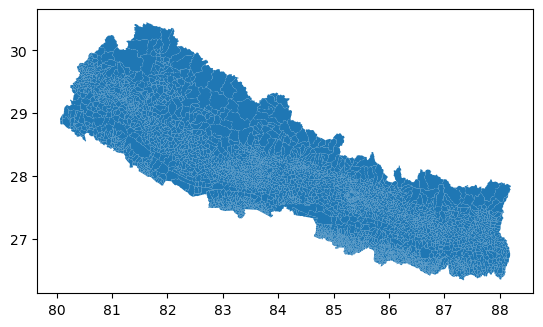

In [10]:
shapes.plot()

**Now clip the rasters**

In [11]:
# Clip WorldPop Data
out = os.path.join(data_out, 'wp2016_npl.tif')
print(out)
raster_clip(rst_fn = wp_path, polys = shapes, fn_out = out)

./data/wp2016_npl.tif


In [12]:
# Clip LandScan Data
out = os.path.join(data_out, 'ls2015_npl.tif')
print(out)
raster_clip(rst_fn = ls_path, polys = shapes, fn_out = out)

./data/ls2015_npl.tif


In [13]:
# Clip ESRI Data
out = os.path.join(data_out, 'esri2016_npl.tif')
print(out)
raster_clip(rst_fn = esri_path, polys = shapes, fn_out = out)

./data/esri2016_npl.tif


In [14]:
# Clip GHS Data
out = os.path.join(data_out, 'ghs2015_npl.tif')
print(out)
raster_clip(rst_fn = ghs_path, polys = shapes, fn_out = out)

./data/ghs2015_npl.tif


In [15]:
# Clip GPW Data
out = os.path.join(data_out, 'gpw2015_npl.tif')
print(out)
raster_clip(rst_fn = gpw_path, polys = shapes, fn_out = out)

./data/gpw2015_npl.tif


In [16]:
# Clip modis data
out = os.path.join(data_out, 'modis2015_npl.tif')
print(out)
raster_clip(rst_fn = modis_path, polys = shapes, fn_out = out)

./data/modis2015_npl.tif


<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

### Spatially align (match) and reproject the population rasters

Now, we need to match and reproject the population rasters. We also need each raster to have the same `nan` value. In other words, we need reach popgrid raster to be in the same CRS, have the same shape, nan value, and projection so that they stack. <br>

Let's take a look at the `crs`, `shape` and `nan` of each raster.


<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [17]:
wp_path = os.path.join(data_out, 'wp2016_npl.tif')
ls_path = os.path.join(data_out, 'ls2015_npl.tif')
esri_path = os.path.join(data_out, 'esri2016_npl.tif')
ghs_path = os.path.join(data_out, 'ghs2015_npl.tif')
gpw_path = os.path.join(data_out, 'gpw2015_npl.tif')
modis_path = os.path.join(data_out, 'modis2015_npl.tif')

In [18]:
# MODIS2015_LCType2_1km-urban.tif is 2015 MODIS from GEE reclassified to urban/rural 
# width = ??? 
# height = ???
# crs = ???
modis = rio.open_rasterio(modis_path)
print(modis.rio.crs)
modis

EPSG:4326


<xarray.DataArray (band: 1, y: 914, x: 1814)> Size: 2MB
[1657996 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 15kB 80.06 80.06 80.07 80.07 ... 88.19 88.2 88.2
  * y            (y) float64 7kB 30.45 30.44 30.44 30.43 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [19]:
# GPW v4 : 
# width = ??? 
# height = ???
# crs = ???
gpw = rio.open_rasterio(gpw_path)
print(gpw.rio.crs)
gpw

EPSG:4326


<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
[482154 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.402823e+38
    scale_factor:   1.0
    add_offset:     0.0

In [20]:
# World Pop 2016 
# width = ??? 
# height = ???
wp = rio.open_rasterio(wp_path)
print(wp.rio.crs)
wp

EPSG:4326


<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
[482154 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.19 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

In [21]:
# ESRI 2016 
# width = ??? 
# height = ???
# crs = ???
esri = rio.open_rasterio(esri_path)
print(esri.rio.crs)
esri

EPSG:4326


<xarray.DataArray (band: 1, y: 457, x: 908)> Size: 2MB
[414956 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.21
  * y            (y) float64 4kB 30.44 30.43 30.43 30.42 ... 26.36 26.36 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -2147483647
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
# LS 2015 
# width = ??? 
# height = ???
# crs = ???
ls = rio.open_rasterio(ls_path)
print(ls.rio.crs)
ls

EPSG:4326


<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
[482154 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -2147483647
    scale_factor:   1.0
    add_offset:     0.0

In [23]:
# GHS 2015 
# width = ??? 
# height = ???
# crs = ???
ghs = rio.open_rasterio(ghs_path)
print(ghs.rio.crs)
ghs

EPSG:4326


<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 4MB
[482154 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -200.0
    scale_factor:   1.0
    add_offset:     0.0

#### Dealing with NaN values for the rasters.

**First check the nan `nodata` for all data** <br>
This is the meta data flag that says "this value means nan" _and_ print this value when we see an `nan'. 

In [24]:
# Check no data values
print(modis.rio.nodata)
print(gpw.rio.nodata)
print(esri.rio.nodata)
print(ls.rio.nodata)
print(wp.rio.nodata)
print(ghs.rio.nodata)

None
-3.402823e+38
-2147483647
-2147483647
-3.4028235e+38
-200.0


Now, let's check the nan values for all data by looking at the value upper left corner of each array.

In [25]:
print('modis nan value is', modis.data[0][0][0])
print('GPW nan value is', gpw.data[0][0][0])
print('World Pop nan value is', wp.data[0][0][0])
print('LandScan nan value is', ls.data[0][0][0])
print('ESRI nan value is', esri.data[0][0][0])
print('GHS nan value is', ghs.data[0][0][0])

modis nan value is 0
GPW nan value is -3.402823e+38
World Pop nan value is -3.4028235e+38
LandScan nan value is -2147483647
ESRI nan value is -2147483647
GHS nan value is -200.0


In [26]:
# Let's revalue everywhere that is <= 0 since we only care about population
modis.data = np.where(modis.data < 1,0, modis.data)
gpw.data = np.where(gpw.data < 1,0, gpw.data)
wp.data = np.where(wp.data < 1,0, wp.data)
ls.data = np.where(ls.data < 1,0, ls.data)
esri.data = np.where(esri.data < 1,0, esri.data)
ghs.data = np.where(ghs.data < 1,0, ghs.data)

In [27]:
# check them out
print('modis na value is', modis.data[0][0][0])
print('GPW na value is', gpw.data[0][0][0])
print('World Pop na value is', wp.data[0][0][0])
print('LandScan na value is', ls.data[0][0][0])
print('ESRI na value is', esri.data[0][0][0])
print('GHS na value is', ghs.data[0][0][0])

modis na value is 0
GPW na value is 0.0
World Pop na value is 0.0
LandScan na value is 0
ESRI na value is 0
GHS na value is 0.0


In [28]:
# check the data type of modis
print(modis.dtype)
modis.data = modis.data.astype('int16')
print(modis.dtype)

uint8
int16


In [29]:
# Let's set a nodata values for all
modis.rio.write_nodata(-999, inplace=True)
print(modis.rio.nodata)
gpw.rio.write_nodata(-999, inplace=True)
print(gpw.rio.nodata)
wp.rio.write_nodata(-999, inplace=True)
print(wp.rio.nodata)
ls.rio.write_nodata(-999, inplace=True)
print(ls.rio.nodata)
esri.rio.write_nodata(-999, inplace=True)
print(esri.rio.nodata)
ghs.rio.write_nodata(-999, inplace=True)
print(ghs.rio.nodata)

-999
-999.0
-999.0
-999
-999
-999.0


In [30]:
# Check no data values
print(modis.rio.nodata)
print(gpw.rio.nodata)
print(esri.rio.nodata)
print(ls.rio.nodata)
print(wp.rio.nodata)
print(ghs.rio.nodata)

-999
-999.0
-999
-999
-999.0
-999.0


**Check the nan `_FillValue` for all data** <br>
This is the meta data flag that says "this value means nan" _and_ print this value when we see an `nan'. 

In [31]:
# modis doesn't have an assigned fill value so we make one
modis.attrs['_FillValue'] = -999

# Check fille values
print(modis.attrs['_FillValue'])
print(gpw.attrs['_FillValue'])
print(esri.attrs['_FillValue'])
print(ls.attrs['_FillValue'])
print(wp.attrs['_FillValue'])
print(ghs.attrs['_FillValue'])

-999
-999.0
-999
-999
-999.0
-999.0


In [32]:
# Set all nan fill values to 0 in the meta data
na_val = -999

modis.attrs['_FillValue'] = na_val
gpw.attrs['_FillValue'] = na_val
esri.attrs['_FillValue'] = na_val
ls.attrs['_FillValue'] = na_val
wp.attrs['_FillValue'] = na_val
ghs.attrs['_FillValue'] = na_val

In [33]:
# Check nan fill values in the meta data
print(modis.attrs['_FillValue'])
print(gpw.attrs['_FillValue'])
print(esri.attrs['_FillValue'])
print(ls.attrs['_FillValue'])
print(wp.attrs['_FillValue'])
print(ghs.attrs['_FillValue'])

-999
-999
-999
-999
-999
-999


**Reproject rasters** <br>
Now we pick one raster, and reproject and match the other rasters to a single basemap. This choice is arbitrary and would benefit with a sensitivity analysis (e.g. trying different raster to see how reprojecting changes the data), but we'll use GPWv4 because it is the underlying data for many of the other products.

In [34]:
# Reproject all datasets to GPWv4
modis_match = modis.rio.reproject_match(gpw)
gpw_match = gpw.rio.reproject_match(gpw) # this is not needed per say, but we're doing it for consistancy
ls_match = ls.rio.reproject_match(gpw)
esri_match = esri.rio.reproject_match(gpw)
wp_match = wp.rio.reproject_match(gpw)
ghs_match = ghs.rio.reproject_match(gpw)

**Now check the reprojected data**

In [35]:
modis_match

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 964kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int16)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999

In [36]:
gpw_match

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999.0

In [37]:
ls_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999

In [38]:
esri_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999

In [39]:
wp_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 2MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999.0

In [40]:
ghs_match 

<xarray.DataArray (band: 1, y: 493, x: 978)> Size: 4MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB 80.06 80.07 80.08 80.09 ... 88.19 88.2 88.2
  * y            (y) float64 4kB 30.45 30.44 30.43 30.42 ... 26.36 26.35 26.35
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -999.0

**Now write the reprojected and matched rasters to disk**

Notice that `MGUP15_2015-1km-matched.tif` uses `-` not `_` ... this helps later when we want to use `glob` to get the files we want to work with.

In [41]:
# Now write the reprojected and matched rasters
modis_match.rio.to_raster(data_out + 'MGUP15_2015-1km-npl-matched.tif') 
gpw_match.rio.to_raster(data_out + 'gpw2015_npl_matched.tif')
esri_match.rio.to_raster(data_out + 'esri2016_npl_matched.tif')
ls_match.rio.to_raster(data_out + 'ls2015_npl_matched.tif')
wp_match.rio.to_raster(data_out + 'wp2016_npl_matched.tif')
ghs_match.rio.to_raster(data_out + 'ghs2015_npl_matched.tif')

<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

### Mask Rural and Urban Populations

Now, we will create a mask to use the binary `MGUP` rural-urban populations to isolate urban populations and rural populations for each popgrid raster <br>


<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [42]:
def raster_mask(rst_fn, lc_arr, data_out):
    """
    Masks and separates population raster data into urban and rural regions based on a binary classification layer, and writes the results to separate output files.

    Args:
        rst_fn (str): The file path and name of the input population raster (.tif).
        lc_arr (numpy.array): A binary array representing land cover, where urban areas are indicated by 1 and rural areas are indicated by values other than 1 (e.g., -999).
        data_out (str): The directory path where the resulting urban and rural raster files will be saved.

    Process:
        1. Opens the input population raster and reads it as an array.
        2. Applies a mask to separate urban (land cover == 1) and rural (land cover != 1) population data.
        3. Updates the metadata to match the new raster data.
        4. Saves the masked urban and rural rasters as new files with modified filenames.

    Output:
        - Two GeoTIFF files: one for the urban population and one for the rural population.
        - Filenames will be derived from the input raster name and will end with '_urban.tif' and '_rural.tif'.

    Example:
        raster_mask('population.tif', landcover_array, 'output_directory/')

    Notes:
        - The input raster should be in GeoTIFF (.tif) format.
        - Ensure that the land cover array has the same dimensions as the population raster.
        - The function writes two output files, one for the urban population and one for the rural population.
    """
    
    # split for naming
    rst_nm = rst_fn.split('a/')[1].split('.tif')[0]
    print(rst_nm)
    
    # open pop rasters and get array
    arr = rasterio.open(rst_fn).read(1)
    mask = np.where(arr == -999, 0, 1) # make an NaN mask 
    
    # multiply for urban
    lc_urban = lc_arr == 1
    arr_urban = arr * lc_urban * mask
    
    # multiply for rural
    lc_rural = lc_arr != 1
    arr_rural = arr * lc_rural * mask

    # meta data
    meta = rasterio.open(rst_fn).meta

    # write out urban
    meta['nodata'] = -999
    meta['dtype'] = arr_urban.dtype
    out_fn = data_out+rst_nm+'_urban.tif'
    print(out_fn)
    with rasterio.open(out_fn, 'w', **meta) as out:
        out.write_band(1, arr_urban)
    
    # write out rural 
    meta['nodata'] = -999
    meta['dtype'] = arr_rural.dtype
    out_fn = data_out+rst_nm+'_rural.tif'
    print(out_fn)
    with rasterio.open(out_fn, 'w', **meta) as out:
        out.write_band(1, arr_rural)
    print('done \n')

In [43]:
# Make a rural/urban raster (MGUP rural value == 0)
urban_rural = modis_match.copy()
urban_rural.data = np.where(urban_rural.data == 0, 0, urban_rural.data)
urban_rural.data = np.where(urban_rural.data != 1, 0, urban_rural.data)
urban_rural.rio.to_raster(data_out+'MGUP15-rural-urban-matched.tif')
modis_arr = rasterio.open(data_out+'MGUP15-rural-urban-matched.tif').read(1)

In [44]:
# Git matched tif files
rst_fns = sorted(glob(data_out + '*_npl_matched.tif'))
rst_fns

['./data/esri2016_npl_matched.tif',
 './data/ghs2015_npl_matched.tif',
 './data/gpw2015_npl_matched.tif',
 './data/ls2015_npl_matched.tif',
 './data/wp2016_npl_matched.tif']

In [45]:
# Mask all the rasters and save them 
for rst_fn in rst_fns:
    raster_mask(rst_fn, modis_arr, data_out)

esri2016_npl_matched
./data/esri2016_npl_matched_urban.tif
./data/esri2016_npl_matched_rural.tif
done 

ghs2015_npl_matched
./data/ghs2015_npl_matched_urban.tif
./data/ghs2015_npl_matched_rural.tif
done 

gpw2015_npl_matched
./data/gpw2015_npl_matched_urban.tif
./data/gpw2015_npl_matched_rural.tif
done 

ls2015_npl_matched
./data/ls2015_npl_matched_urban.tif
./data/ls2015_npl_matched_rural.tif
done 

wp2016_npl_matched
./data/wp2016_npl_matched_urban.tif
./data/wp2016_npl_matched_rural.tif
done 



<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

### Estimate Population Exposure to Quake by Intensity 

Now we will dive into estimating how many people were impacted by the quake by earth quake intensity for each population raster, isolating urban from rural populations. <br>

We are using **USGS Shakemap intensity contours** recorded during the earthquake. You can read about these data [here](https://databasin.org/datasets/9411dd80be424001ac7af150f8d3b7b0/). 

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [46]:
def poly_prep(polys_fn, col):
    """
    Prepares polygon data for use in zonal statistics calculations by opening the file and subsetting the necessary columns.

    Args:
        polys_fn (str): The file path to the polygon shapefile or GeoJSON file containing the polygons.
        col (str): The column name in the polygon file that will be retained along with the geometry for later use in the zonal statistics calculations.

    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame containing only the geometry and the specified column from the input file.

    Process:
        1. Opens the polygon file using `geopandas.read_file()`.
        2. Subsets the data to keep only the 'geometry' column and the specified column (`col`).
        3. Returns the prepared GeoDataFrame for further use in zonal statistics or other spatial analyses.

    Example:
        polygons = poly_prep('earthquake_polygons.shp', 'admin_level')

    Notes:
        - Ensure that the input file is in a format readable by `geopandas`, such as a shapefile (.shp) or GeoJSON (.geojson).
        - The column specified by `col` should be present in the input file, as it will be retained for later analysis.
    """    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

In [47]:
# Open the shape map polygons
nepal_polys_fn = os.path.join(data_in + 'USGS_Data/Nepal/shape/mi.shp')

In [48]:
# Subset the polygons
col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)
nepal_polys.head()

,geometry,PARAMVALUE
0,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31...",2.8
1,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31...",3.0
2,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31...",3.2
3,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31...",3.4
4,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31...",3.6


Plot the MI shape file with the GPWv4 population data

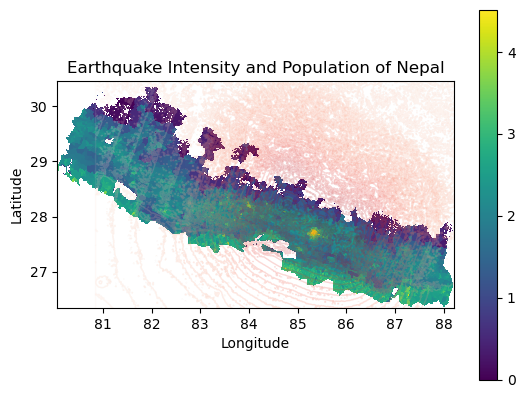

In [49]:
# your code here ... 

# Open the raster file using rioxarray
raster = rio.open_rasterio('./data/gpw2015_npl_matched.tif')

# Apply a mask to avoid NaN and non-positive values, preserving the spatial metadata
raster_clean = raster.where(raster > 0)  # Only keep positive values, mask NaNs and zeros

# Apply the log scale to the raster data, preserving metadata
raster_clean.data = np.log10(raster_clean.data)  # Apply log transformation to the data array directly

# Create the plot
fig, ax = plt.subplots()

# Plot the raster
raster_clean.plot(ax=ax, cmap='viridis', vmin = 0)  # You can change the colormap as needed

# Plot the shapefile on top of the raster
nepal_polys.plot(ax=ax, column = 'PARAMVALUE', cmap = 'Reds', facecolor = 'None', alpha = 0.1)

# Set titles and labels if needed
ax.set_title('Earthquake Intensity and Population of Nepal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

Plot the MI shape file with the GPWv4 population data **Zoomed over Kathmandu**

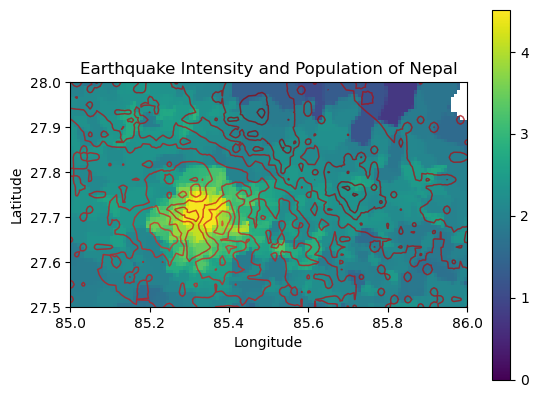

In [50]:
# Create the plot
fig, ax = plt.subplots()

# Plot the raster
raster_clean.plot(ax=ax, cmap='viridis', vmin = 0)  # You can change the colormap as needed

# Plot the shapefile on top of the raster
nepal_polys.plot(ax=ax, column = 'PARAMVALUE', cmap = 'Reds', facecolor = 'None', alpha = 0.5)

# Set xlim and ylim
plt.xlim([85,86])
plt.ylim([27.5,28])

# Set titles and labels if needed
ax.set_title('Earthquake Intensity and Population of Nepal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

We need a function to extract the zonal stats. Check out the one below:

In [51]:
# Functions
def zone_loop(polys_in, rst_list, stats_type, col, split):
    """
    Loops through a list of rasters, calculates zonal statistics for each polygon, and returns the results as a merged GeoDataFrame.

    Args:
        polys_in (geopandas.GeoDataFrame): A GeoDataFrame containing the polygons for which zonal statistics will be calculated.
        rst_list (list of str): A list of file paths to the rasters (.tif) on which zonal statistics will be performed.
        stats_type (str): The type of statistic to calculate for each polygon (e.g., 'mean', 'sum', 'min', 'max'). See the `zonal_stats` function for available options.
        col (str): The column name in `polys_in` that will be used to merge the zonal statistics results.
        split (str): A string delimiter used to split and extract a portion of the raster file name for labeling the output columns (e.g., "_matched.tif").

    Process:
        1. Creates a copy of the input polygon GeoDataFrame (`polys_in`) to hold the resulting zonal statistics.
        2. Loops through each raster in `rst_list`:
           - Extracts a meaningful name from the raster file name using the provided `split` string.
           - Computes zonal statistics for the polygons on the current raster.
           - Converts the results to a GeoDataFrame and renames the statistics column with the extracted name.
           - Merges the zonal statistics results with the original polygon GeoDataFrame on the specified column (`col`).
        3. Returns the final GeoDataFrame containing the original polygons and the calculated zonal statistics from all rasters.

    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame with the original polygons and added columns for zonal statistics from each raster.

    Example:
        result = zone_loop(polygons, ['raster1.tif', 'raster2.tif'], 'mean', 'id_column', '_matched.tif')

    Notes:
        - The `zonal_stats` function is used to compute the statistics. Ensure that it is properly imported from `rasterstats`.
        - The `split` argument should match part of the file name to correctly parse it for labeling the output.
        - The resulting columns in the output GeoDataFrame will be named based on the raster file name and the `stats_type` (e.g., 'raster1_mean').
    """    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        print(rst)
        data = rst.split('data/')[1].split(split)[0].split('.tif')[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out

### All Data
Extract the population exposed by intensity contour.

In [52]:
# Git tif files
rst_fns = sorted(glob(data_out + '*npl_matched.tif'))
rst_fns

['./data/esri2016_npl_matched.tif',
 './data/ghs2015_npl_matched.tif',
 './data/gpw2015_npl_matched.tif',
 './data/ls2015_npl_matched.tif',
 './data/wp2016_npl_matched.tif']

In [53]:
# Notice we need to remove the modis data
# rst_fns.remove('./data/modis2015_npl.tif')
# rst_fns

In [54]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(polys_in = nepal_polys, rst_list = rst_fns, stats_type = 'sum', col = 'PARAMVALUE', split = '_npl.tif')

./data/esri2016_npl_matched.tif
Started esri2016_npl_matched
./data/ghs2015_npl_matched.tif
Started ghs2015_npl_matched
./data/gpw2015_npl_matched.tif
Started gpw2015_npl_matched
./data/ls2015_npl_matched.tif
Started ls2015_npl_matched
./data/wp2016_npl_matched.tif
Started wp2016_npl_matched


In [55]:
# Check the data
nepal_polys_sum.head()

,geometry,PARAMVALUE,esri2016_npl_matched_sum,ghs2015_npl_matched_sum,gpw2015_npl_matched_sum,ls2015_npl_matched_sum,wp2016_npl_matched_sum
0,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31...",2.8,NaN,NaN,NaN,NaN,NaN
1,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31...",3.0,NaN,NaN,NaN,NaN,NaN
2,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31...",3.2,NaN,NaN,NaN,NaN,NaN
3,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31...",3.4,28931.0,24170.360793,26196.789062,29991.0,25714.810547
4,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31...",3.6,440101.0,327079.838195,366582.750000,398353.0,358166.906250


In [56]:
# Save the data
fn_out = os.path.join(data_out + 'nepal_all_quake_pop.shp')
fn_out

'./data/nepal_all_quake_pop.shp'

In [ ]:
nepal_polys_sum.to_file(fn_out)

/tmp/ipykernel_5632/2071035444.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nepal_polys_sum.to_file(fn_out)


### Urban Data
Extract the urban population exposed by intensity contour.

In [ ]:
# Git urban tif files
rst_fns = sorted(glob(data_out + '*urban.tif'))
rst_fns

In [ ]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(polys_in = nepal_polys, rst_list = rst_fns, stats_type = 'sum', col = 'PARAMVALUE', split = '_npl-matched_urban.tif')

In [ ]:
# Check the data
nepal_polys_sum.head()

In [ ]:
# Save the poly sums
fn_out = os.path.join(data_out + 'nepal_urban_quake_pop.shp')
fn_out

In [ ]:
nepal_polys_sum.to_file(fn_out)

### Rural Data

In [ ]:
# Git rural tif files
rst_fns = sorted(glob(data_out + '*rural.tif'))
rst_fns

In [ ]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(polys_in = nepal_polys, rst_list = rst_fns, stats_type = 'sum', col = 'PARAMVALUE', split = '_npl-matched_rural.tif')

In [ ]:
# Check the data
nepal_polys_sum.head()

In [ ]:
# Save the poly sums
fn_out = os.path.join(data_out + 'nepal_rural_quake_pop.shp')
fn_out

In [ ]:
nepal_polys_sum.to_file(fn_out)

## Let's double check the data
The urban and rural data should equal the total data. But let's check it out! 

In [ ]:
# All
fn_in = os.path.join(data_out + 'nepal_all_quake_pop.shp')
all_pop = gpd.read_file(fn_in)
all_pop.head()

In [ ]:
# Urban
fn_in = os.path.join(data_out + 'nepal_urban_quake_pop.shp')
urban_pop = gpd.read_file(fn_in)
urban_pop.head()

In [ ]:
# Rural 
fn_in = os.path.join(data_out + 'nepal_rural_quake_pop.shp')
rural_pop = gpd.read_file(fn_in)
rural_pop.head()

In [ ]:
# Check the data 
top = (rural_pop.iloc[:,1:6] + urban_pop.iloc[:,1:6]).values
bottom = all_pop.iloc[:,1:6]

In [ ]:
top / bottom

<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

# Bar Plot
Let's look at how exposure levels, but urban and rural populations, compare across quake intensities.

**Colors** <br>
Reminder that there are a ton of named colors available in [`matplotlib`](https://matplotlib.org/stable/gallery/color/named_colors.html). Check em out ane pick some!

In [ ]:
# set colors
ESRI16_c = 'blue'
GHS15_c = 'indigo'
GPWv4_c = 'deeppink'
LS15_c = 'deepskyblue'
WP16_c = 'forestgreen'

In [ ]:
# Open the shape files 
npl_all_fn = os.path.join(data_out + 'nepal_all_quake_pop.shp')
npl_all = gpd.read_file(npl_all_fn)

npl_rural_fn = os.path.join(data_out + 'nepal_rural_quake_pop.shp')
npl_rural = gpd.read_file(npl_rural_fn)

npl_urban_fn = os.path.join(data_out + 'nepal_urban_quake_pop.shp')
npl_urban = gpd.read_file(npl_urban_fn)

In [ ]:
# Make data
def group(df):
    """
    Groups and sums population data by Modified Mercalli Intensity (MI) ranges and returns a summary DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame containing population data and earthquake intensity values.
            - The DataFrame should have a 'PARAMVALUE' column representing the Modified Mercalli Intensity (MI) levels.
            - Population data should be in columns 1 to 6 (index positions 1:6), which will be summed for each intensity range.

    Process:
        1. Filters and sums population data for the following MI ranges:
           - MI range 4.0 to 4.9 (IV)
           - MI range 5.0 to 5.9 (V)
           - MI range 6.0 to 6.9 (VI)
           - MI 7.0 and above (VII)
        2. Sums the population data for each intensity range.
        3. Creates a DataFrame with the summed population data for each MI range.
        4. Transposes the resulting DataFrame to display MI ranges as rows and population categories as columns.

    Returns:
        pandas.DataFrame: A transposed DataFrame where each row corresponds to an MI range ('iv', 'v', 'vi', 'vii'), and the columns represent the summed population data across categories.

    Example:
        result = group_and_sum_population_by_MI_ranges(quake_population_df)

    Notes:
        - Ensure that the 'PARAMVALUE' column contains MI values, and that columns 1 to 6 hold population data.
        - The returned DataFrame will have the MI ranges as rows and the summed population data for each range as columns.
    """
    
    iv = df[(df['PARAMVALUE'] >= 4) & (df['PARAMVALUE'] < 5)].iloc[:, 1:6].sum(axis=0)
    v = df[(df['PARAMVALUE'] >= 5) & (df['PARAMVALUE'] < 6)].iloc[:, 1:6].sum(axis=0)
    vi = df[(df['PARAMVALUE'] >= 6) & (df['PARAMVALUE'] < 7)].iloc[:, 1:6].sum(axis=0)
    vii = df[df['PARAMVALUE'] >= 7].iloc[:, 1:6].sum(axis=0)
    
    out = pd.DataFrame()
    out['iv'] = iv
    out['v'] = v
    out['vi'] = vi
    out['vii'] = vii
    
    out = out.transpose()
    return out

In [ ]:
# check out the function
group(npl_all)

In [ ]:
# check out the function
group(npl_rural)

In [ ]:
# Make bar plot 
fig, axs = plt.subplots(1, 1, figsize = (12, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**6

# All Quake
data = group(npl_all)

# Bar locations
a = [1-.3,2-.3,3-.3, 4-.3]
b = [1-.15,2-.15,3-.15,4-.15]
c = [1,2,3,4]
d = [1+.15,2+.15,3+.15,4+.15]
e = [1+.3,2+.3,3+.3,4+.3]

# plots
plt.bar(a, data.esri2016_n / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black')
plt.bar(b, data.ghs2015_np / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black')
plt.bar(c, data.gpw2015_np / scale, width=0.12, align='center', alpha  = 0.7, color = GPWv4_c, ec = 'black')
plt.bar(d, data.ls2015_npl / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black')
plt.bar(e, data.wp2016_npl / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black')

# Fake plot for rural hatch legend 
plt.bar(e, data.wp2016_npl / scale, width=0.12, align='center', alpha  = 0, color = 'white', ec = 'black',hatch = "///")

# rural quake
data = group(npl_rural)
plt.bar(a, data.esri2016_n / scale, width=0.12, align='center', alpha  = 0.5, color = ESRI16_c, ec = 'black', hatch = "///")
plt.bar(b, data.ghs2015_np / scale, width=0.12, align='center', alpha  = 0.6, color = GHS15_c, ec = 'black', hatch = "///")
plt.bar(c, data.gpw2015_np / scale, width=0.12, align='center', alpha  = 0.7, color = GPWv4_c, ec = 'black', hatch = "///")
plt.bar(d, data.ls2015_npl / scale, width=0.12, align='center', alpha  = 0.8, color = LS15_c, ec = 'black', hatch = "///")
plt.bar(e, data.wp2016_npl / scale, width=0.12, align='center', alpha  = 0.9, color = WP16_c, ec = 'black', hatch = "///")

# legend
legend_elements = [patches.Patch(facecolor=ESRI16_c, alpha = 0.5, edgecolor=None, label='WPE-15'),
                  patches.Patch(facecolor=GHS15_c, alpha = 0.6, edgecolor=None, label='GHSL-15'),
                  patches.Patch(facecolor=GPWv4_c, alpha = 0.7, edgecolor=None, label='GPW-15'),
                  patches.Patch(facecolor=LS15_c, alpha = 0.8, edgecolor=None, label='LS-15'),
                  patches.Patch(facecolor= WP16_c, alpha = 0.9, edgecolor=None, label='WP-16'),
                  patches.Patch(facecolor= 'white', alpha = 0.9,  hatch = '///', edgecolor='black', label='rural pop')]
plt.legend(handles = legend_elements, bbox_to_anchor=(1, 1.02), loc='upper left', ncol=1, fontsize = 15);

# Labels / Titles
axs.set_title('Nepal 2015 Earthquake Impact', size = 20)
axs.set_xlabel('Instrumental Intesnity', fontsize = 15)
axs.set_ylabel('Total Population [millions]', fontsize = 15)

# Ticks
ticks_bar = ['>=4', ' >=5', '>=6', '>=7'];
plt.xticks([1,2,3,4], ticks_bar, fontsize = 15);
plt.yticks(fontsize = 15);

In [ ]:
# save it out
fig_out = os.path.join(data_out + 'Figure.png')
fig_out

In [ ]:
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

In [ ]:
fn = './data/esri2016_npl_matched.tif'

In [ ]:
rasterio.open(fn).read(1)